In [76]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE # Pour visualiser l'espace latent 2D
from torchvision.utils import make_grid

# Imports locaux
from model import CCVAE
from dataset import CartoonMultiLabelDataset
from torchvision import transforms

# Config
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "ccvae_multilabel.pth"
DATA_DIR = "./cartoonset10k/cartoonset10k"
BATCH_SIZE = 128 # On prend un gros batch pour avoir plein de points pour le t-SNE

print(f"Working on {DEVICE}")

Working on cuda


In [ ]:
# 1. Dataset & Loader
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])
dataset = CartoonMultiLabelDataset(root_dir=DATA_DIR, transform=transform,target_attributes=["hair_color", "face_color"])
# Shuffle=True pour avoir des classes variées
test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)







Chargement des labels pour : ['hair_color', 'face_color'] ...
Dataset chargé. Attributs: {'hair_color': 10, 'face_color': 11}


In [77]:
# 2. Charger le modèle
Z_C_DIMS = [16, 16] 
Z_NOT_C_DIM = 32
model = CCVAE(
        img_channels=3,
        z_c_dims=Z_C_DIMS,       # Liste [16, 16]
        z_not_c_dim=Z_NOT_C_DIM, 
        num_classes_list= [10, 11]
    ).to(DEVICE)

In [78]:
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()
print("Modèle chargé et en mode eval().")

Modèle chargé et en mode eval().


In [79]:
# 3. Récupérer un batch de référence
data_iter = iter(test_loader)
fixed_x, fixed_y = next(data_iter)
fixed_x = fixed_x.to(DEVICE)
fixed_y = fixed_y.to(DEVICE)

## Basic blocks

In [80]:
def encode_to_z(model, x):
    """
    x : (1, 3, 64, 64)
    Retourne :
        z : (1, total_dim) - Le vecteur complet
        z_c_list : [tensor(1, 16), tensor(1, 16)] - Liste des latents par attribut
        z_not_c : (1, 32) - Le style non-supervisé
    """
    with torch.no_grad():
        h = model.encoder_conv(x)
        mu = model.fc_mu(h)
        # On utilise mu (déterministe) pour l'analyse, ou reparameterize pour le sampling
        # Ici on prend mu pour être propre en inférence
        z = mu 
        
        # Slicing pour récupérer les morceaux
        split_sizes = model.z_c_dims + [model.z_not_c_dim]
        z_parts = torch.split(z, split_sizes, dim=1)
        
        z_c_list = z_parts[:-1] # Liste des z_c_i
        z_not_c = z_parts[-1]   # Le dernier morceau

    return z, z_c_list, z_not_c

def probas_from_zc(model, z_c_list):
    """
    z_c_list : Liste de tenseurs [z_c_hair, z_c_face]
    Retourne :
        probs_list : Liste de tenseurs de probabilités [(1, 10), (1, 11)]
    """
    probs_list = []
    with torch.no_grad():
        for i, z_c_i in enumerate(z_c_list):
            logits = model.classifiers[i](z_c_i)
            probs = F.softmax(logits, dim=1)
            probs_list.append(probs)
    return probs_list

def classify_x(model, x):
    """
    x : (1, 3, 64, 64)
    Retourne :
        preds : Liste d'entiers [pred_hair, pred_face]
        probs_list : Liste des tenseurs de probas
    """
    z, z_c_list, _ = encode_to_z(model, x)
    probs_list = probas_from_zc(model, z_c_list)
    
    preds = []
    for probs in probs_list:
        pred_item = torch.argmax(probs, dim=1).item()
        preds.append(pred_item)

    return preds, probs_list

def generate_random(model, device='cuda'):
    """
    Génère une image totalement aléatoire.
    """
    with torch.no_grad():
        z_parts = []
        
        # 1. Aléatoire pour les attributs (z_c)
        for dim in model.z_c_dims:
            z_parts.append(torch.randn(1, dim).to(device))
            
        # 2. Aléatoire pour le style (z_not_c)
        z_parts.append(torch.randn(1, model.z_not_c_dim).to(device))
        
        # 3. Concaténation et Décodage
        z = torch.cat(z_parts, dim=1)
        dec = model.decoder_input(z).view(-1, 64, 4, 4)
        x_gen = model.decoder_conv(dec)

    return x_gen

def generate_conditional(model, class_idxs, device='cuda'):
    """
    class_idxs : Liste d'entiers [idx_hair, idx_face]
                 Ex: [0, 5] -> Cheveux classe 0, Visage classe 5
    """
    with torch.no_grad():
        z_parts = []
        
        # Pour chaque attribut, on génère le z_c correspondant via son Prior
        for i, class_idx in enumerate(class_idxs):
            # Préparation du label
            y = torch.tensor([class_idx], device=device)
            num_cls = model.num_classes_list[i]
            y_onehot = F.one_hot(y, num_classes=num_cls).float()
            
            # Passage dans le réseau Prior (Embedding -> Mu)
            # Attention: model.priors_embedding est une ModuleList
            embed = F.relu(model.priors_embedding[i](y_onehot))
            mu_prior = model.priors_mu[i](embed)
            
            # On utilise la moyenne du prior (c'est le "centre" de la classe)
            z_parts.append(mu_prior)
            
        # Ajout du style aléatoire (z_not_c)
        z_parts.append(torch.randn(1, model.z_not_c_dim).to(device))
        
        # Concaténation
        z = torch.cat(z_parts, dim=1)
        
        # Décodage
        dec = model.decoder_input(z).view(-1, 64, 4, 4)
        x_gen = model.decoder_conv(dec)

    return x_gen

def show_tensor_image(img_tensor, title="Image générée"):
    img = img_tensor.squeeze(0).detach().cpu()
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    
    plt.figure(figsize=(3,3))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()



In [81]:
x_test, y_test = dataset[0] 

# 2. Ajout de la dimension Batch (B=1)
# x_test passe de (3, 64, 64) -> (1, 3, 64, 64)
x_test = x_test.unsqueeze(0).to(DEVICE)

# y_test est un tensor([L1, L2]). On le passe en (1, 2)
y_test = y_test.unsqueeze(0).to(DEVICE)

print(f"Input x shape : {x_test.shape}")
print(f"Input y val   : {y_test.tolist()} (Shape: {y_test.shape})")

# 3. Encodage
# Attention : encode_to_z retourne z_c_list (une liste), pas un seul tenseur !
z, z_c_list, z_not_c = encode_to_z(model, x_test)

# 4. Affichage des dimensions
print(f"z (total) shape : {z.shape}") # Devrait être 16+16+32 = 64

print("--- Détail z_c (par attribut) ---")
for i, z_c_part in enumerate(z_c_list):
    # z_c_part est un tenseur (1, 16)
    attr_name = dataset.target_attributes[i] if hasattr(dataset, 'target_attributes') else f"Attr {i}"
    print(f"  z_c_{i} ({attr_name}) shape : {z_c_part.shape}")

print(f"z_not_c (style) shape : {z_not_c.shape}")

Input x shape : torch.Size([1, 3, 64, 64])
Input y val   : [[9, 10]] (Shape: torch.Size([1, 2]))
z (total) shape : torch.Size([1, 64])
--- Détail z_c (par attribut) ---
  z_c_0 (hair_color) shape : torch.Size([1, 16])
  z_c_1 (face_color) shape : torch.Size([1, 16])
z_not_c (style) shape : torch.Size([1, 32])


In [82]:
z_c_list

(tensor([[-9.1124, -4.2646, -2.6162,  1.8582, -1.4213,  6.8292,  2.3319, -7.8142,
          -1.0526, -7.4937,  0.7102,  1.3939,  0.4115, -7.6358, -6.6595,  7.7053]],
        device='cuda:0'),
 tensor([[ 3.6921, -3.0023,  2.9026,  3.0615,  6.0175, -4.3414, -4.9290, -0.3906,
           4.6623,  6.9146, -0.6397, -3.8172, -1.0737,  2.1270, -1.7655,  2.6481]],
        device='cuda:0'))

In [83]:
# 1. Probabilités (Attention : c'est une liste de tenseurs maintenant)
# z_c_list a été obtenu à l'étape précédente via encode_to_z
probs_list = probas_from_zc(model, z_c_list)

print("--- Shapes des probabilités ---")
for i, p in enumerate(probs_list):
    print(f"  Attribut {i} : {p.shape}") 
    # Ex: (1, 10) pour hair, (1, 11) pour face

# 2. Classification
preds, all_probs = classify_x(model, x_test)
print(f"\nPrédictions prédites : {preds}")      # Ex: [4, 8]
print(f"Vrais labels         : {y_test.tolist()}") # Ex: [[4, 8]]



--- Shapes des probabilités ---
  Attribut 0 : torch.Size([1, 10])
  Attribut 1 : torch.Size([1, 11])

Prédictions prédites : [9, 8]
Vrais labels         : [[9, 10]]


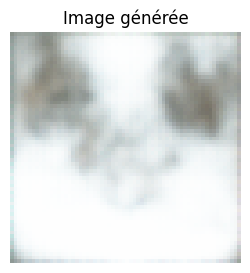

In [84]:
show_tensor_image(generate_random(model))

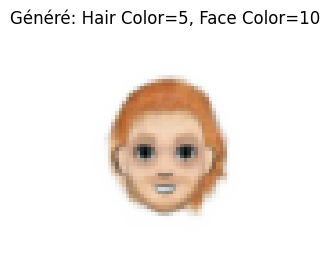

In [85]:
# 3. Génération Conditionnelle
# On veut : Cheveux = classe 6, Visage = classe 5
# Il faut passer une LISTE [6, 5]
target_classes = [5, 10] 
x_gen_cond = generate_conditional(model, target_classes, device=DEVICE)

show_tensor_image(x_gen_cond, title=f"Généré: Hair Color={target_classes[0]}, Face Color={target_classes[1]}")

## Visualizations and tests

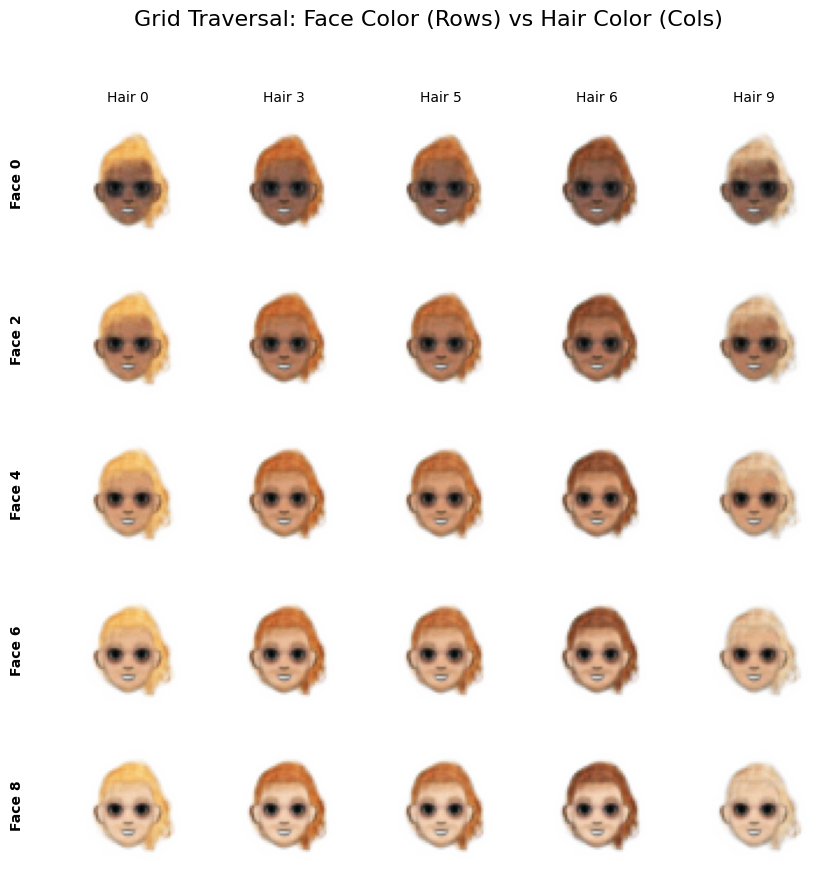

In [86]:
def plot_latent_grid(model, hair_indices, face_indices, fixed_z_not_c=None, device='cuda'):
    """
    Génère une grille d'images :
      - Colonnes : Variation de hair_color (selon hair_indices)
      - Lignes   : Variation de face_color (selon face_indices)
      - Le style (forme, background) est fixé par fixed_z_not_c.
    """
    model.eval()
    
    # 1. Si pas de style fixé, on en génère un aléatoire
    if fixed_z_not_c is None:
        # On génère un bruit aléatoire pour le style (z_not_c)
        fixed_z_not_c = torch.randn(1, model.z_not_c_dim).to(device)
    else:
        # S'assurer qu'il est sur le bon device et bonne dimension
        fixed_z_not_c = fixed_z_not_c.to(device)
        if fixed_z_not_c.dim() == 1:
            fixed_z_not_c = fixed_z_not_c.unsqueeze(0)

    # Préparation de la figure Matplotlib
    nrows = len(face_indices)
    ncols = len(hair_indices)
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(2 * ncols, 2 * nrows))
    plt.subplots_adjust(wspace=0.05, hspace=0.05) # Réduire l'espace entre images

    # Titre global
    fig.suptitle(f"Grid Traversal: Face Color (Rows) vs Hair Color (Cols)", fontsize=16)

    with torch.no_grad():
        for row_idx, f_idx in enumerate(face_indices):
            for col_idx, h_idx in enumerate(hair_indices):
                
                # --- Construction du vecteur Latent z ---
                z_parts = []
                
                # A. Partie Hair Color (Index 0 dans ton modèle multi-label)
                y_hair = torch.tensor([h_idx]).to(device)
                y_hair_onehot = F.one_hot(y_hair, num_classes=model.num_classes_list[0]).float()
                emb_hair = F.relu(model.priors_embedding[0](y_hair_onehot))
                z_c_hair = model.priors_mu[0](emb_hair) # On prend la moyenne du prior
                z_parts.append(z_c_hair)
                
                # B. Partie Face Color (Index 1 dans ton modèle multi-label)
                y_face = torch.tensor([f_idx]).to(device)
                y_face_onehot = F.one_hot(y_face, num_classes=model.num_classes_list[1]).float()
                emb_face = F.relu(model.priors_embedding[1](y_face_onehot))
                z_c_face = model.priors_mu[1](emb_face) # On prend la moyenne du prior
                z_parts.append(z_c_face)
                
                # C. Partie Style (Fixe)
                z_parts.append(fixed_z_not_c)
                
                # D. Concaténation et Décodage
                z = torch.cat(z_parts, dim=1)
                dec_in = model.decoder_input(z).view(-1, 64, 4, 4)
                recon = model.decoder_conv(dec_in)
                
                # --- Affichage ---
                # Gestion du cas où il n'y a qu'une ligne ou colonne (axes n'est pas 2D)
                if nrows == 1 and ncols == 1:
                    ax = axes
                elif nrows == 1:
                    ax = axes[col_idx]
                elif ncols == 1:
                    ax = axes[row_idx]
                else:
                    ax = axes[row_idx, col_idx]
                
                # Conversion Tensor -> Numpy Image
                img = recon.squeeze(0).cpu().permute(1, 2, 0).numpy()
                img = np.clip(img, 0, 1)
                
                ax.imshow(img)
                ax.axis('off') # On cache les axes chiffrés
                
                # Ajout des labels sur les bords seulement
                if row_idx == 0:
                    ax.set_title(f"Hair {h_idx}", fontsize=10)
                if col_idx == 0:
                    # Astuce pour mettre du texte à gauche (Label des lignes)
                    ax.text(-0.2, 0.5, f"Face {f_idx}", 
                            transform=ax.transAxes, 
                            va='center', ha='right', rotation=90, fontsize=10, fontweight='bold')

    plt.show()

# =========================================================
# EXEMPLE D'UTILISATION
# =========================================================

# 1. Définir quels indices on veut voir
# Tu peux mettre range(10) pour tout voir, ou une sélection pour zoomer
hair_selection = [0, 3, 5, 6, 9] # Ex: 5 couleurs de cheveux
face_selection = [0, 2, 4, 6, 8] # Ex: 5 teintes de visage

# 2. Récupérer un "Style" fixe depuis une image réelle du dataset (Pour garder une identité réaliste)
x_real, _ = dataset[12] # On prend l'image 12 au hasard
x_real = x_real.unsqueeze(0).to(DEVICE)
_, _, z_style_real = encode_to_z(model, x_real) # On extrait son z_not_c

# 3. Lancer la visualisation
plot_latent_grid(
    model, 
    hair_indices=hair_selection, 
    face_indices=face_selection, 
    fixed_z_not_c=z_style_real, # On utilise le style de l'image 12
    device=DEVICE
)

# Optionnel : Essayer avec un style totalement aléatoire
# plot_latent_grid(model, hair_selection, face_selection, fixed_z_not_c=None, device=DEVICE)

Génération des données pour la matrice de confusion : Hair Color...


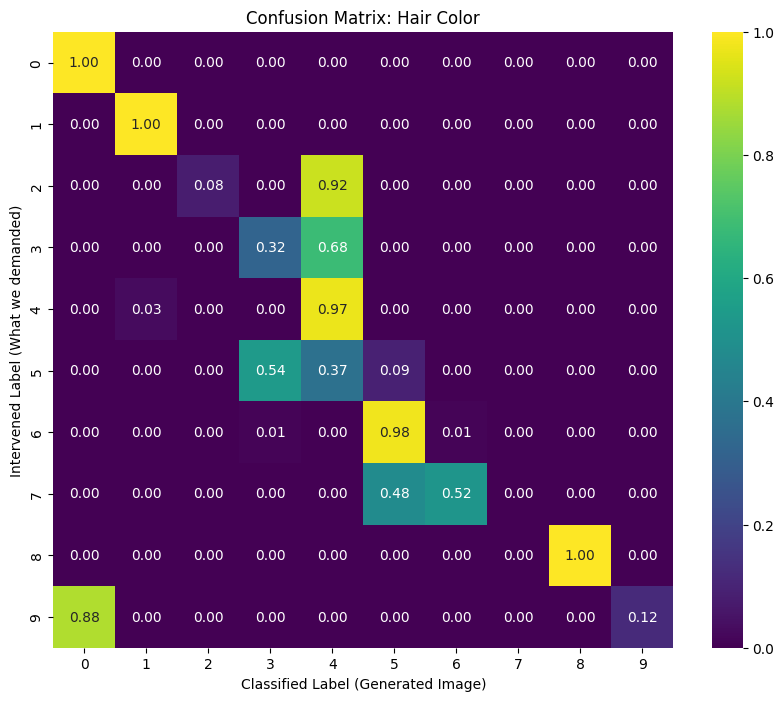

Génération des données pour la matrice de confusion : Face Color...


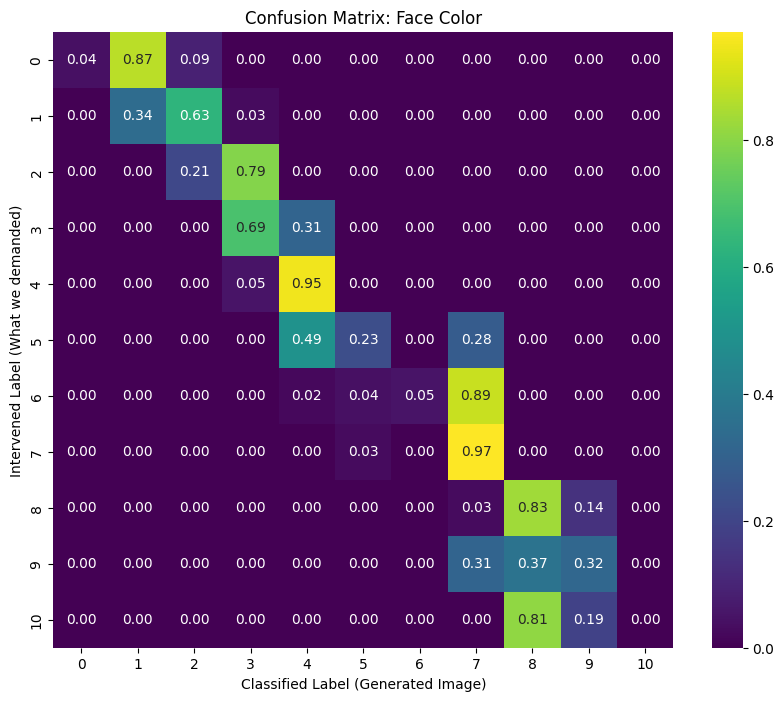

In [87]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_intervention_confusion_matrix(model, attribute_index, attribute_name, device='cuda'):
    """
    Génère la matrice de confusion pour un attribut donné (0=Hair, 1=Face).
    On force le modèle à générer chaque classe, et on vérifie s'il la reconnaît ensuite.
    """
    model.eval()
    num_classes = model.num_classes_list[attribute_index]
    
    y_true = [] # Ce qu'on a demandé (Intervened)
    y_pred = [] # Ce que le modèle a généré (Classified)

    print(f"Génération des données pour la matrice de confusion : {attribute_name}...")
    
    with torch.no_grad():
        # On teste chaque classe possible
        for class_idx in range(num_classes):
            # On génère un batch de 100 images pour cette classe spécifique
            batch_size = 100
            
            # 1. Création des vecteurs latents
            z_parts = []
            
            # Pour chaque attribut, on construit son z_c
            for i in range(model.num_attributes):
                if i == attribute_index:
                    # C'est l'attribut qu'on force (L'axe Y de la matrice)
                    target_y = torch.full((batch_size,), class_idx, dtype=torch.long).to(device)
                    y_onehot = F.one_hot(target_y, num_classes=model.num_classes_list[i]).float()
                    
                    # On utilise le Prior pour obtenir le z_c idéal de cette classe
                    embed = F.relu(model.priors_embedding[i](y_onehot))
                    mu_prior = model.priors_mu[i](embed)
                    z_parts.append(mu_prior)
                else:
                    # Pour l'autre attribut (ex: Face), on met du bruit ou une classe fixe (ex: 0)
                    # Ici on met une classe aléatoire pour tester la robustesse
                    rand_y = torch.randint(0, model.num_classes_list[i], (batch_size,)).to(device)
                    y_onehot = F.one_hot(rand_y, num_classes=model.num_classes_list[i]).float()
                    embed = F.relu(model.priors_embedding[i](y_onehot))
                    mu_prior = model.priors_mu[i](embed)
                    z_parts.append(mu_prior)

            # Ajout du style aléatoire (z_not_c)
            z_not_c = torch.randn(batch_size, model.z_not_c_dim).to(device)
            z_parts.append(z_not_c)
            
            # 2. Génération de l'image (Decode)
            z = torch.cat(z_parts, dim=1)
            dec = model.decoder_input(z).view(-1, 64, 4, 4)
            x_gen = model.decoder_conv(dec)
            
            # 3. Re-Classification (Encode -> Classify)
            # On regarde si l'image générée est bien classée comme "class_idx"
            _, _, _, logits_list, _, _ = model(x_gen)
            
            # On récupère les prédictions pour l'attribut concerné
            preds = torch.argmax(logits_list[attribute_index], dim=1)
            
            # Stockage
            y_true.extend([class_idx] * batch_size)
            y_pred.extend(preds.cpu().numpy())

    # Calcul de la matrice
    cm = confusion_matrix(y_true, y_pred, normalize='true') # Normalize pour avoir des % (0 à 1)

    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="viridis", 
                xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel("Classified Label (Generated Image)")
    plt.ylabel("Intervened Label (What we demanded)")
    plt.title(f"Confusion Matrix: {attribute_name}")
    plt.show()

# =======================================================
# EXECUTION
# =======================================================

# 1. Matrice pour les Cheveux (Index 0)
plot_intervention_confusion_matrix(model, attribute_index=0, attribute_name="Hair Color", device=DEVICE)

# 2. Matrice pour le Visage (Index 1)
plot_intervention_confusion_matrix(model, attribute_index=1, attribute_name="Face Color", device=DEVICE)

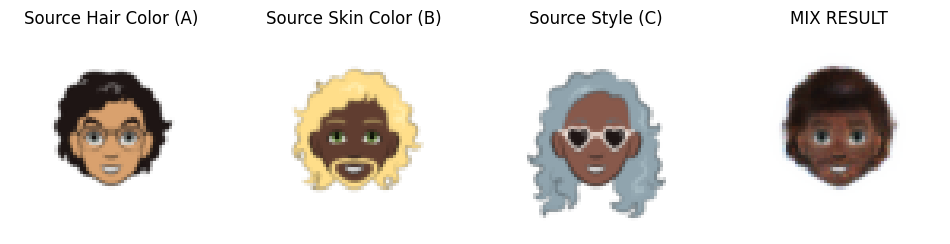

In [88]:
def mix_and_match_3way(model, dataset, device='cuda'):
    """
    Prend 3 images au hasard et combine leurs attributs.
    """
    model.eval()
    
    # On pioche 3 images au hasard dans le dataset
    indices = torch.randperm(len(dataset))[:3]
    
    img_A, _ = dataset[indices[0]] # Source Cheveux
    img_B, _ = dataset[indices[1]] # Source Peau
    img_C, _ = dataset[indices[2]] # Source Style
    
    # Batch dimension
    img_A = img_A.unsqueeze(0).to(device)
    img_B = img_B.unsqueeze(0).to(device)
    img_C = img_C.unsqueeze(0).to(device)
    
    with torch.no_grad():
        # Encodage
        _, z_c_list_A, _ = encode_to_z(model, img_A)
        _, z_c_list_B, _ = encode_to_z(model, img_B)
        _, _, z_not_c_C = encode_to_z(model, img_C)
        
        # MIX : Z_Hair de A + Z_Face de B + Z_Style de C
        # Attention : z_c_list = [z_hair, z_face]
        z_mix = torch.cat([z_c_list_A[0], z_c_list_B[1], z_not_c_C], dim=1)
        
        # Décodage
        dec = model.decoder_input(z_mix).view(-1, 64, 4, 4)
        x_mix = model.decoder_conv(dec)
        
    # Visualisation
    imgs = [img_A, img_B, img_C, x_mix]
    titles = ["Source Hair Color (A)", "Source Skin Color (B)", "Source Style (C)", "MIX RESULT"]
    
    plt.figure(figsize=(12, 4))
    for i in range(4):
        plt.subplot(1, 4, i+1)
        im = imgs[i].squeeze(0).cpu().permute(1,2,0).numpy()
        plt.imshow(np.clip(im, 0, 1))
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

# Lancer le test
mix_and_match_3way(model, dataset, device=DEVICE)

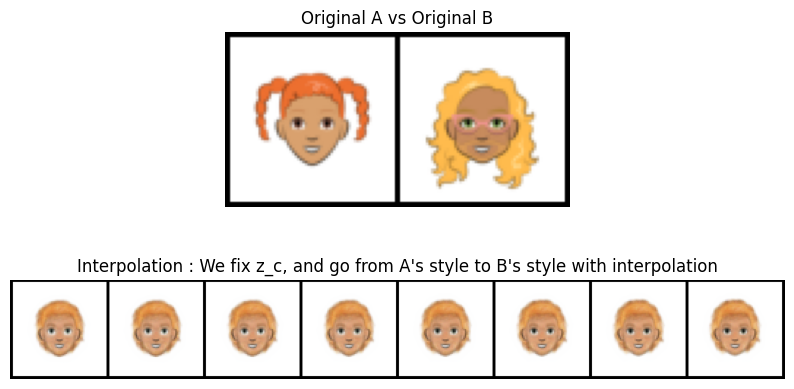

In [89]:
def interpolate_style(model, dataset, device='cuda', steps=8):
    model.eval()
    
    # 1. On pioche deux images ET leurs labels
    idx1, idx2 = torch.randperm(len(dataset))[:2]
    
    img1, label1 = dataset[idx1] # label1 contient [hair_idx, face_idx] de l'image A
    img2, _      = dataset[idx2]
    
    img1 = img1.unsqueeze(0).to(device)
    img2 = img2.unsqueeze(0).to(device)
    
    with torch.no_grad():
        # 2. On extrait les STYLES (z_not_c) des deux images
        _, _, z_style_1 = encode_to_z(model, img1)
        _, _, z_style_2 = encode_to_z(model, img2)
        
        # 3. ON FIXE LA COULEUR = CELLE DE L'IMAGE A (C'est ça le changement !)
        # Au lieu de mettre 6 et 5 au pif, on prend les vraies couleurs de A
        target_hair = label1[0].item()
        target_face = label1[1].item()
        
        # On génère les vecteurs latents pour ces couleurs fixes via le Prior
        y_hair = F.one_hot(torch.tensor([target_hair], device=device), num_classes=10).float()
        z_hair = model.priors_mu[0](F.relu(model.priors_embedding[0](y_hair)))

        y_face = F.one_hot(torch.tensor([target_face], device=device), num_classes=11).float()
        z_face = model.priors_mu[1](F.relu(model.priors_embedding[1](y_face)))

        # 4. Interpolation
        alphas = np.linspace(0, 1, steps)
        interpolated_imgs = []
        
        for alpha in alphas:
            # On glisse du style A vers le style B
            z_style_interp = (1 - alpha) * z_style_1 + alpha * z_style_2
            
            # Mais on garde TOUJOURS la couleur de A (z_hair, z_face fixes)
            z = torch.cat([z_hair, z_face, z_style_interp], dim=1)
            
            dec = model.decoder_input(z).view(-1, 64, 4, 4)
            img = model.decoder_conv(dec)
            interpolated_imgs.append(img)
            
    # --- Affichage ---
    plt.figure(figsize=(10, 5))
    
    # Ligne du haut : Les originaux (La réalité)
    plt.subplot(2, 1, 1)
    # On concatène pour afficher A et B côte à côte
    grid_src = make_grid(torch.cat([img1, img2], dim=0), nrow=2)
    plt.imshow(grid_src.cpu().permute(1, 2, 0).numpy())
    plt.title(f"Original A vs Original B")
    plt.axis('off')
    
    # Ligne du bas : L'interpolation
    plt.subplot(2, 1, 2)
    grid_interp = make_grid(torch.cat(interpolated_imgs, dim=0), nrow=steps)
    plt.imshow(grid_interp.cpu().permute(1, 2, 0).numpy())
    plt.title(f"Interpolation : We fix z_c, and go from A's style to B's style with interpolation")
    plt.axis('off')
    
    plt.show()

# Lancer ce test
interpolate_style(model, dataset, device=DEVICE)